In [ ]:
import numpy as np
import pandas as pd
import logging
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [32]:
import sompy
from sompy.sompy import SOMFactory

In [33]:
from tfprop_sompy.jupyter_integration.cluster_inspector import sort_materials_by_cluster, cluster_tabs

In [34]:
from tfprop_sompy.tfprop_vis import render_posmap_to_axes, kmeans_clust, show_posmap, ViewTFP, dataframe_to_coords , clusteringmap_category

In [35]:
# This makes all the loggers stay quiet unless it's important
logging.getLogger().setLevel(logging.WARNING)

In [36]:
# Paste name of file generated by training in Sompy_experimentation
CODEBOOK_FILE = 'som_codemat_4props_20-02-05.h5'

KM_CLUSTERS = 5

In [37]:
# Creates necessary pd dataframes for visualization
stored_cb_matrix = pd.read_hdf(CODEBOOK_FILE, 'sm_codebook_matrix')
stored_mapsize = pd.read_hdf(CODEBOOK_FILE, 'sm_codebook_mapsize').values
mats_df = pd.read_hdf(CODEBOOK_FILE, 'sm_data')

# FIXME:
# We do a hack using the "pytables" library in order to extract the information
# For some reason pandas doesn't like to read object series out of h5 files
stored_columns = None
stored_matfamilies = None
with tables.open_file(CODEBOOK_FILE, "r") as store:
    # We normally get byte strings from this
    # The mapping operation turns them all into unicode strings ready for presentation
    stored_columns = list(map(lambda x: x.decode('utf-8'), store.root.sm_codebook_columns.property_names.read()))
    stored_matfamilies = list(map(lambda x: x, store.root.sm_codebook_matfamilies.material_families.read()))


In [38]:
mats_df["Row"] = stored_matfamilies


In [39]:
sm = SOMFactory.build(mats_df[stored_columns].values, 
                mapsize=(*stored_mapsize,),
                normalization="var", 
                initialization="pca", 
                component_names=stored_columns)

In [40]:
sm.codebook.matrix = stored_cb_matrix.values

In [15]:
def create_posmap(mysom: sompy.sompy.SOM, num_clusters: int=KM_CLUSTERS):
    cl_labels = kmeans_clust(mysom, n_clusters=num_clusters)

    # plot positioning map with clustered groups
    show_posmap(mysom, mats_name_df, mats_name_df,
                num_clusters, cl_labels,
                show_data=False, labels=False)

In [16]:
cl_labels = kmeans_clust(sm, KM_CLUSTERS)

Performing K-means clustering to SOM trained data...


In [17]:
heatmap_size = (20, 20)
heatmap_col_sz = 4
gauss_alpha = None

cmap = plt.get_cmap('RdYlBu_r')  # set color map
viewTFP = ViewTFP(*heatmap_size, '', stdev_colorscale_coeff=1., text_size=14)

In [18]:
my_out = widgets.Output()

# No scaling
viewTFP.knee_value = 0.0
with my_out:
    print("Linear scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap, isOutHtmap=False)
my_out

Output()

In [19]:
my_out = widgets.Output()
cmap = plt.get_cmap('RdYlBu_r')  # set color map

# No scaling
viewTFP.knee_value = 0.0
with my_out:
    print("Log scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap, normalizer="log")
my_out

Output()

In [17]:
# viewTFP2 = ViewTFP(*(7, 7), '', stdev_colorscale_coeff=1,text_size=14)
# for i, p in enumerate(stored_columns):
#     viewTFP2.show(sm, cl_labels, col_sz=1,
#                      which_dim=i, desnormalize=True, col_norm='mean',
#                      cmap=cmap, normalizer="log", isOutHtmap=False)

In [18]:
# from sompy.visualization.mapview import View2D

# my_out = widgets.Output()
# cmap = plt.get_cmap('RdYlBu_r')  # set color map

# view2d = View2D(*heatmap_size, '', stdev_colorscale_coeff=1., text_size=14)
# # No scaling
# viewTFP.knee_value = 0.0
# with my_out:
#     print("Log scaling")
#     viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
#                          which_dim='all', desnormalize=True, col_norm='mean',
#                          cmap=cmap, normalizer="log")
# my_out

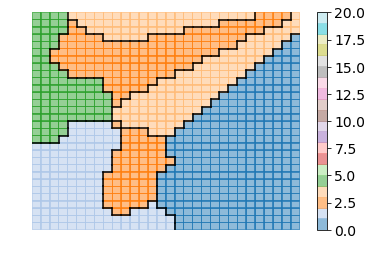

In [20]:
## %matplotlib inline
my_dataframe = mats_df
clusters_list = sort_materials_by_cluster(sm, my_dataframe, cl_labels)

# This makes it so it will display the full lists
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# This should be the last statement of the cell, to make it display
# That, or assign the return value to a variable, and have that variable be the final expression in a cell
cluster_tabs(sm, my_dataframe, clusters_list, cl_labels)

NameError: name 'clusteringmap_category' is not defined

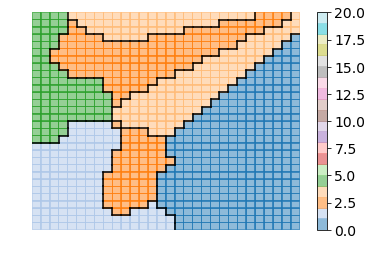

In [22]:
from tfprop_sompy.jupyter_integration.cluster_inspector import make_cluster_graph
from tfprop_sompy.tfprop_vis import dataframe_to_coords, render_points_to_axes

fig, ax = make_cluster_graph(sm, cl_labels)
clusteringmap_category(ax, sm, KM_CLUSTERS, my_dataframe, "Top_Film_(Coded)", my_dataframe["Row"], 'plot.png')


C:\Users\Felic\Miniconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


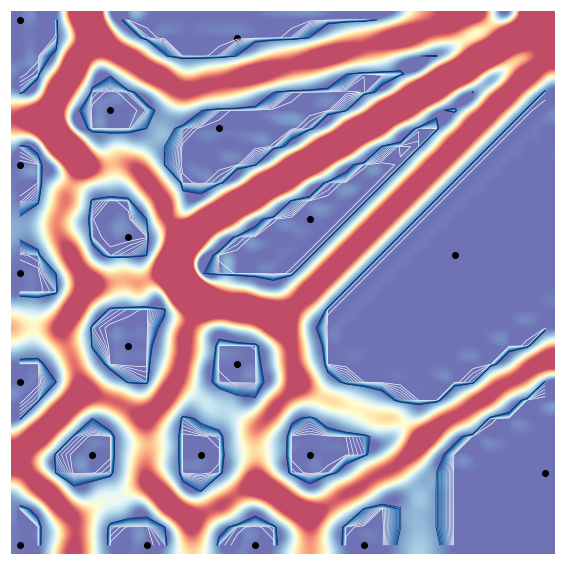

In [24]:
from tfprop_sompy.tfprop_vis import UMatrixTFP

umat_size = (50, 50)

umat = UMatrixTFP(*umat_size, 'U-matrix')

umat.show(sm, my_dataframe, my_dataframe, cmap=cmap)
None

In [25]:
sm.calculate_quantization_error()

2.350085193184026e-07

In [26]:
sm.calculate_topographic_error()

0.0

In [27]:
# Run cells below this one manually
# Used for testing code
assert False

AssertionError: 